In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, HDFStore
import matplotlib.pyplot as plt
import datetime as dt
import sqlite3
import pandas_datareader.data as web

import quandl as ql

In [2]:
# main       = HDFStore('database/main.h5')
# currencies = main['currencies']
# xetra      = main['xetra']

cnx        = sqlite3.connect('database/stocks_main.db')
xetra      = pd.read_sql("SELECT * FROM XETRA;", cnx)
currencies = pd.read_sql("SELECT * FROM currencies", cnx)

In [3]:
class keyratios:
    def __init__(self,filename):
        self.load(filename)
    
    def load_keyratios(self,filename):
        try:
            self.keyratios = pd.read_csv(filename,skiprows=2)
        except IOError:
            self.keyratios = None
            return
        self._correct_colnames()
        self.keyratios = self._format_keyratios()
    
    def _correct_colnames(self):
        newcols = []
        for i in self.keyratios.columns:
            if i == 'TTM':
                newcols.append(newcols[-1]+1)
                continue
            if 'Unnamed' in i:
                newcols.append('year')
                continue 
            newcols.append(int(i.split('-')[0]))
        self.keyratios.columns = newcols

    def _format_keyratios(self):
        pdf = self.keyratios
        pdf = pdf.transpose()
        
        cols_new     = []
        cols_to_use  = []

        cols_old = np.array(pdf[pdf.index=='year'])[0]
        
        currency = self._find_currency(cols_old)
        
        
        for string in cols_old:
    #         print string
            try:
                newstring = string
                newstring = newstring.replace(' ','')
                newstring = newstring.replace('%', '')
                newstring = newstring.replace('Mil','')
                newstring = newstring.replace('*','')
                newstring = newstring.replace('(','')
                newstring = newstring.replace(')','')

                for j in currencies.currency:
                    newstring = newstring.replace(j,'')
            except AttributeError:
                newstring = 'NaN'

            if newstring in cols_new:
                newstring = '{0}_{1}'.format(newstring,len(cols_new)+1)
            cols_new.append(newstring)    

        try:
            pdf.columns = cols_new
        except ValueError:
            return cols_old,cols_new
        pdf         = pdf[1:]


        for c in cols_new:
            if '_' not in c and '&' not in c:
                if c not in ['NaN','3-YearAverage','Efficiency','MarginsofSales','Growth',
                             'BalanceSheetItemsin','Liquidity/FinancialHealth','Profitability',
                             'CashFlowRatios']:
                    cols_to_use.append(c)


        pdf = pdf[cols_to_use]
        pdf = pdf.replace(to_replace=",",value="",regex=True)    


        pdf = pdf.astype('float')


        pdf = pdf[[
                    'Shares',
                    'Revenue',
                    'EarningsPerShare',
                    'Dividends',
                    'BookValuePerShare',
                    'OperatingCashFlow',
                    'ReturnonEquity',
                    'GrossMargin',
                    'OperatingIncome', 
                    'OperatingMargin',
                    'NetIncome',
                    'CapSpending',
                    'FreeCashFlow', 
                    'FreeCashFlowPerShare', 
                    'WorkingCapital', 
                    'COGS',
                    'EBTMargin', 
                    'TaxRate', 
                    'NetMargin',
                    'AssetTurnoverAverage', 
                    'ReturnonAssets',
                    'FinancialLeverageAverage',
                    'ReturnonInvestedCapital', 
                    'InterestCoverage' 
                   ]]

        pdf.currency = currency

        return pdf    

    def _find_currency(self,cols_old):
        for cur in currencies.currency:
            if 'Earnings Per Share {0}'.format(cur) in cols_old:
#                 print 'ISIN {0} found currency: {1}'.format(self.isin,cur)
                return cur
    

In [4]:
class quotes:
    def __init__(self):
        pass
    
    def _get_quote_quandl(self):
        isin, ticker = self.isin, self.ticker
        
        if isin[0:2]=='DE':
            prefix = "FSE/"
            suffix = "_X"
            key = "{0}{1}{2}".format(prefix,ticker,suffix)
            df  = ql.get(key, authtoken="CkyBkkkbzfh3ePfDF_ip")
            df  = df[['Open','High','Low','Close','Traded Volume']]
            df.columns = ['Open','High','Low','Close','Volume'] 
#             df.reset_index(level=0, inplace=True)
            
        elif isin[0:2]=='CH':
            key = "SIX/{0}CHF1".format(self.isin)
            df  = ql.get(key, authtoken="CkyBkkkbzfh3ePfDF_ip")            
            df.columns = ['Close','Volume']  
            
            
        elif isin[0:2]=='US':
            df = ql.get_table('WIKI/PRICES',ticker=ticker, paginate=True)
            df = df[['date','open','high','low','close','volume']]
            df.columns = ['Date','Open','High','Low','Close','Volume']
            
        if 'Date' not in df.index:
            df.reset_index(level=0, inplace=True)
            
        self.quote = df
        
    def _get_quote_google(self,isin,ticker):
        if isin[0:2]=='DE':
            prefix="FRA:"
        elif isin[0:2]=='CH':
            prefix="SIX"
        elif isin[0:2]=='US':
            prefix='NYSE'
            
        key = "{0}{1}".format(prefix,ticker)
        df  = web.DataReader(key, 'google', start, end)
        self.quote = df
    
    def _find_splits(self):
        relchange   = self.quote.Close.diff()/self.quote.Close
        self.splits = (relchange[relchange<-0.5]*(-1)+ 1).round()

        for i,splitdate in enumerate(self.quote.loc[self.splits.index].Date):
            self.quote.loc[self.quote.Date < 
                        splitdate,'Close'] = self.quote.loc[self.quote.Date < 
                                                         splitdate,'Close']/np.array(self.splits)[i]        
        
        
    def get_quote(self, find_splits=True):
        for func in [self._get_quote_quandl, self._get_quote_google]:
            try:
                func()
                break
            except:
                continue
        if not find_splits:
            return
        
        try:
            self._find_splits()
        except AttributeError:
            self.quote = None
            pass

In [5]:
class stocks(keyratios,quotes):
    def __init__(self,stocklist,index=0,ISIN=None,verbose=False):
        self.list  = stocklist

        if ISIN:
            self.switch_isin(ISIN)
        else:
            self.switch_index(index)
        self._update_tables()
        
    def switch_isin(self,isin):
        df         = self.list[self.list.ISIN==isin]
        self.index = df.index[0]
        self.name, self.isin, self.ticker = np.array(df)[0]
        self._update_tables()
        
    def switch_index(self,index):
        self.index = index
        df         = self.list[self.list.index==index]
        self.name, self.isin, self.ticker = np.array(df)[0]
#         self._update_tables()
        
    def switch_next(self):
        try:
            self.switch_index(self.index+1)
            self._update_tables()
            self.quote = None
        except IndexError:
            pass

    def _update_tables(self):
        try:
            self.load_keyratios('ms_keyratios/'+self.ticker+'.csv')
        except:
            self.keyratios = None

# Get quotes
## German stocks

### Test the get_quote function

In [6]:
s = stocks(xetra)
s.switch_isin('DE0008430026')
s.get_quote()

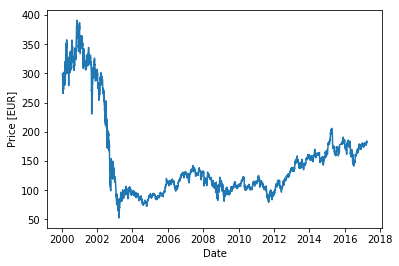

In [7]:
plt.plot(s.quote.Date,s.quote.Close)
plt.xlabel('Date')
plt.ylabel('Price [EUR]')
plt.show()

### Test the split correction algo

In [301]:
s = stocks(xetra)
s.switch_isin('DE0005790430')
s.get_quote(find_splits=False)

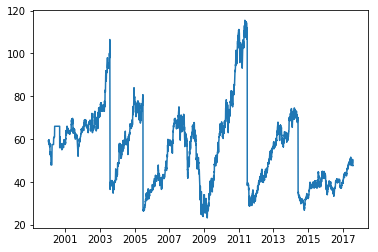

In [302]:
plt.plot(s.quote.Date,s.quote.Close)
plt.show()

In [303]:
s = stocks(xetra)
s.switch_isin('DE0005790430')
s.get_quote(find_splits=True)

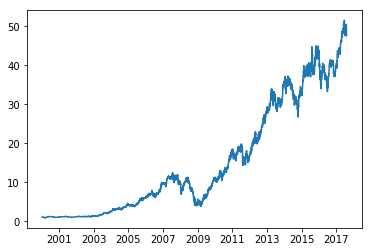

In [304]:
plt.plot(s.quote.Date,s.quote.Close)
plt.show()

## Check for which companies the quote call is successful
### German Stocks

In [9]:
s = stocks(xetra)
s.switch_isin('DE0001218063')

In [10]:
s.ticker, s.name, s.isin

(u'A7A', u'FINLAB AG   NA O.N.', u'DE0001218063')

In [11]:
quote_calls=[]
while s.isin[0:2]=='DE':
    s.get_quote()
    if s.quote is None:
        var = 0
    else:
        var = 1
    quote_calls.append([s.name,s.isin,var])
    s.switch_next()
quote_calls = pd.DataFrame(quote_calls,columns=['name','isin','quote'])

In [14]:
quote_calls[quote_calls.quote==1]

,name,isin,quote
3,SOFTWARE AG O.N.,DE0003304002,1
4,GERRY WEBER INTERNAT.O.N.,DE0003304101,1
11,UTD.INTERNET AG NA,DE0005089031,1
16,QSC AG NA O.N.,DE0005137004,1
17,DEUTSCHE BANK AG NA O.N.,DE0005140008,1
22,BECHTLE AG O.N.,DE0005158703,1
23,BAUER AG,DE0005168108,1
25,BAY.MOTOREN WERKE AG ST,DE0005190003,1
28,BAYWA AG VINK.NA. O.N.,DE0005194062,1
36,BIOTEST AG VZ O.N.,DE0005227235,1


## Swiss stock quotes

In [305]:
s = stocks(xetra)
s.switch_isin('CH0012005267')
print s.name, s.isin, s.ticker
s.get_quote()

NOVARTIS NAM.     SF 0,50 CH0012005267 NOT


In [309]:
s.quote.head().Date

0   2013-06-05
1   2013-06-06
2   2013-06-07
3   2013-06-10
4   2013-06-11
Name: Date, dtype: datetime64[ns]

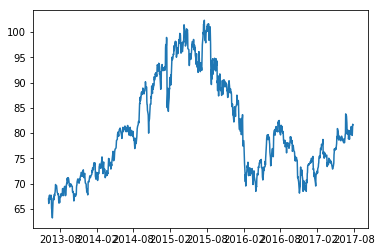

In [308]:
plt.plot(s.quote.Date,s.quote.Close)
plt.show()

In [174]:
s = stocks(xetra)

In [131]:
unsucessful_quote_calls = []

s = stocks(xetra)
s.switch_isin('CH0012005267')
while True:
    if s.isin[0:2]!='CH':
        s.switch_next()
        break
    s.get_quote()
    
    if s.quote is None:
        unsucessful_quote_calls.append([s.name,s.isin,s.ticker])
    
    s.switch_next()

In [132]:
unsucessful_quote_calls

[[u'TECAN GRP AG NAM.SF 0,10', u'CH0012100191', u'TEN'],
 [u'SWATCH GRP AG NAM.SF 0,45', u'CH0012255144', u'UHRN'],
 [u'HELVETIA HOLDING NA SF0,1', u'CH0012271687', u'HVX'],
 [u'STRAUMANN HLDG NA SF 0,10', u'CH0012280076', u'QS5'],
 [u'TEMENOS GROUP AG NA  SF 5', u'CH0012453913', u'TE8N'],
 [u'BACHEM HLDG NA B  SF 0,05', u'CH0012530207', u'BHM'],
 [u'LIFEWATCH AG       SF 1,3', u'CH0012815459', u'GUA1'],
 [u'EMMI AG             SF 10', u'CH0012829898', u'FV6'],
 [u'SIEGFRIED HL NA     SF 2', u'CH0014284498', u'SQG'],
 [u'CIE FINAN.TRAD. INH.', u'CH0014345117', u'CFI'],
 [u'BQUE CANT.VAUD.NAM.SF 10', u'CH0015251710', u'B1V'],
 [u'PARGESA HLDG INH.   SF 20', u'CH0021783391', u'PGH1'],
 [u'ALSO HOLDING AG      SF 1', u'CH0024590272', u'9AS'],
 [u'HUBER+SUHNER NA    SF-,25', u'CH0030380734', u'HGUA'],
 [u'DAETWYLER HLDG INH.SF0,05', u'CH0030486770', u'31D1'],
 [u'SULZER NAM.       SF -,01', u'CH0038388911', u'SUL1'],
 [u'BB BIOTECH NAM.   SF 0,20', u'CH0038389992', u'BBZA'],
 [u'ENERG.DIEN

Conclusion: most of swiss stocks covered with quandl

## US stock quotes

In [318]:
s = stocks(xetra)
s.switch_isin('US7427181091')
print s.name, s.isin, s.ticker
s.get_quote()

PROCTER GAMBLE US7427181091 PRG


In [319]:
s.keyratios

,Shares,Revenue,EarningsPerShare,Dividends,BookValuePerShare,OperatingCashFlow,ReturnonEquity,GrossMargin,OperatingIncome,OperatingMargin,...,WorkingCapital,COGS,EBTMargin,TaxRate,NetMargin,AssetTurnoverAverage,ReturnonAssets,FinancialLeverageAverage,ReturnonInvestedCapital,InterestCoverage
2007,73.0,333.0,0.31,0.25,1.76,17.0,17.05,92.2,38.0,11.4,...,109.0,7.76,9.79,31.19,6.73,1.02,6.90,2.49,12.12,6.02
2008,89.0,836.0,0.32,0.27,2.77,28.0,14.52,94.6,43.0,5.2,...,128.0,5.43,4.35,25.01,3.40,1.61,5.50,2.72,11.20,3.30
2009,99.0,1217.0,0.28,0.28,2.82,56.0,10.41,93.7,51.0,4.2,...,135.0,6.27,3.21,31.14,2.31,1.70,3.93,2.59,8.49,2.93
2010,108.0,1162.0,0.24,0.11,3.14,33.0,7.98,93.3,49.0,4.3,...,176.0,6.68,3.43,34.41,2.25,1.55,3.49,2.06,7.33,3.18
2011,118.0,1206.0,0.08,0.13,2.97,5.0,2.89,90.0,8.0,0.7,...,155.0,10.00,2.32,20.29,0.86,1.62,1.40,2.07,3.51,2.94
2012,120.0,1389.0,0.26,0.16,3.05,48.0,8.61,89.0,52.0,3.7,...,108.0,11.01,3.18,29.32,2.25,1.87,4.21,2.03,6.78,4.53
2013,121.0,1505.0,0.27,0.19,3.19,57.0,8.40,89.6,39.0,2.6,...,112.0,10.39,2.80,23.64,2.14,1.99,4.26,1.92,6.79,5.24
2014,122.0,1428.0,0.25,0.23,3.35,56.0,7.59,90.8,32.0,2.3,...,102.0,9.17,3.06,30.27,2.13,1.92,4.10,1.79,6.26,6.89
2015,122.0,1425.0,0.21,0.25,3.42,66.0,6.20,92.5,34.0,2.4,...,96.0,7.51,2.72,33.74,1.80,1.94,3.50,1.75,5.21,8.12
2016,178.0,2201.0,-0.55,0.26,1.54,59.0,-19.14,94.4,-99.0,-4.5,...,249.0,5.59,-4.17,NaN,-4.45,2.08,-9.28,2.28,-13.34,-7.20


In [328]:
df = ql.get_table('WIKI/PRICES',ticker='AFL', paginate=True)

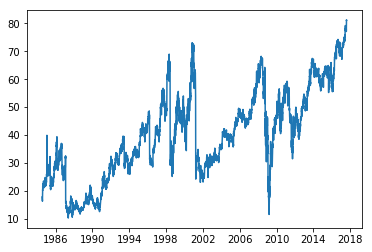

In [329]:
plt.plot(df.date,df.close)
plt.show()

# Save keyratios to database

## Table with currencies

In [14]:
units      = []
emptylist  = []
s = stocks(xetra)

for i in range(0,len(xetra)):    
#     print s.index, s.name, s.isin, s.ticker
    
    try:
        units.append([s.isin,s.keyratios.currency])
    except AttributeError:
        emptylist.append(s.index)
        pass

    s.switch_next()



IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
units = pd.DataFrame(units,columns=['isin','currency'])

In [21]:
bad_ids   = xetra.index.isin(emptylist)          # get the ids for entries without keyratios available
xetra_new = xetra[~bad_ids]                      # xetra list without entries with unavailable keyratios
xetra_new = xetra_new.reset_index(drop=True)     # reset index

In [32]:
# Create your connection.

cnx = sqlite3.connect('database/stocks_main.db')

xetra_new.to_sql('XETRA',cnx,if_exists='append',index=False)
units.to_sql('currencies',cnx,if_exists='replace',index=False)

cnx.close()

# load the new xetra list and populate sql database with keyratios

In [44]:
s   = stocks(xetra)
for _ in xetra.index:
    table = s.is in[0:2]
    cnx = sqlite3.connect('database/keyratios/stocks_keyratios_{0}.db'.format(table))
    s.keyratios.to_s`xql(s.isin,cnx,if_exists='replace',index=True)
    s.switch_next()
    cnx.close()

AttributeError: 'NoneType' object has no attribute 'to_sql'

In [45]:
cnx.close()

# Check keyvalue database consistency

Download link for morningstar api with specification of the region:

http://financials.morningstar.com/ajax/exportKR2CSV.html?t=AMP&region=AUS&culture=en_US

http://financials.morningstar.com/ajax/exportKR2CSV.html?t=BAS&region=DEU&culture=en_US

http://financials.morningstar.com/ajax/exportKR2CSV.html?t=RNO&region=FRA&culture=en_US

http://financials.morningstar.com/ajax/exportKR2CSV.html?t=DCO&region=US&culture=en_US

Script for downloading the keyratios:

    170808_download_keyratios.py

http://financials.morningstar.com/ajax/exportKR2CSV.html?t=FB&region=DEU&culture=en_US

Find mismatches in the downloaded keyratios wrt XETRA list

In [68]:
country = {}
country['AU'] = 'AUS'
country['DE'] = 'DEU'
country['GR'] = 'DEU'
country['US'] = 'DEU'
country['FR'] = 'FRA'
country['CH'] = 'CH'
country['GB'] = 'GB'
country['JP'] = 'JP'

In [69]:
namenotfound = []
of = open('WRONG_ASSOCIATION.dat','w')

for i,v in xetra.iterrows():
    ticker = v.Mnemonic
    isin   = v.ISIN
    
    if isin[0:2] not in country.keys():
        continue
    
    try:
        with open('XETRA_ms_keyratios_new/{0}_{1}.csv'.format(country[isin[0:2]],ticker)) as f:
            for line in f:
                line = line.split('Ratios for')[-1]
                line = line.replace('\n','').replace('.','').lower()
                line = line.replace("'",'')
                name = v.Instrument.split()[0].lower()
                try:
                    if name not in line and line.split()[0] not in name:
                        keyline = line.split('Ratios for')[-1].replace('\n','').upper()
                        name    = v.Instrument
                        of.write('{:50}|{:50}|{:5}\n'.format(keyline, name,ticker)) 
                        namenotfound.append(ticker)
                except UnicodeDecodeError:
                    pass
                break
    except IOError:
        pass
    if i==-1:
        break
of.close()

# Read my fundmentals database

In [11]:
cnx          = sqlite3.connect('database/stocks_keyratios.db')
fundamentals = pd.read_sql("SELECT * FROM fundamentals;", cnx)

In [12]:
fundamentals.ISIN.unique()

array(['AU000000AGG7', 'AU000000AMC4', 'AU000000AMP6', ..., 'USY384721251',
       'USY5217N1183', 'CH0038863350'], dtype=object)

# Basic Algorithms 
## Get fundamentals for current stock

In [48]:
def get_fundamentals(fundamentals, isin):
    return fundamentals[fundamentals.ISIN==isin]

# get earnings growth

In [49]:
df = get_fundamentals(fundamentals, 'DE0008430026')

In [50]:
def get_earnings_growth(df):
    
    '''Returns earnings growth for all companies earning money'''
    
    # select only companies that have earned money in all years taken into account
    if (df.NetIncome < 0).any(): 
        return None
    
    # get the last three years of data [final]
    dff = df[df['year'].between(df.year.max()-2,df.year.max(), inclusive=True)]
    # get the first three years of data [initial]
    dfi = df[df['year'].between(df.year.min(),df.year.min()+2, inclusive=True)]
    
    mean_earnings_final = dff.NetIncome.mean()
    mean_earnings_initi = dfi.NetIncome.mean()
    
    earnings_growth =(mean_earnings_final - mean_earnings_initi)/mean_earnings_initi
    
    if mean_earnings_initi > 0 and mean_earnings_final > 0:
        return earnings_growth
    else:
        return None

In [239]:
data = []
s  = stocks(xetra)
for _ in range(0,len(xetra)):
    df = get_fundamentals(fundamentals, s.isin)
    eg = get_earnings_growth(df)
    if not pd.isnull(eg) and eg<np.inf and eg>-np.inf:
        data.append([s.name,s.isin,eg])
    s.switch_next()
data = pd.DataFrame(data,columns=['name','isin','eg'])

/home/phermes/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [240]:
data

,name,isin,eg
0,AMCOR LTD,AU000000AMC4,0.771912
1,ANSELL LTD.,AU000000ANN9,0.554180
2,A.N.Z. BKG GRP,AU000000ANZ3,0.960640
3,ASX LTD.,AU000000ASX7,0.240493
4,BRAMBLES LTD,AU000000BXB1,0.052288
5,COCA-COLA AMATIL,AU000000CCL2,-0.204367
6,CIMIC GROUP,AU000000CIM7,0.471636
7,COCHLEAR LTD,AU000000COH5,0.239884
8,COMPUTERSHARE LTD.,AU000000CPU5,-0.231031
9,DOMINOS PIZZA ENTERPR.LTD,AU000000DMP0,4.222222


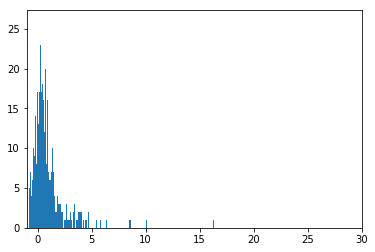

In [161]:
plt.hist(data.eg[data.eg!=0],bins=1000)
plt.xlim(-1,30)
plt.show()

In [163]:
data.eg.describe()

count    682.000000
mean       0.990223
std        2.434721
min       -0.908225
25%        0.035761
50%        0.536502
75%        1.225961
max       46.484878
Name: eg, dtype: float64

In [228]:
dataset1 = data[(data.eg>1.0) & (data.eg<3.0)]

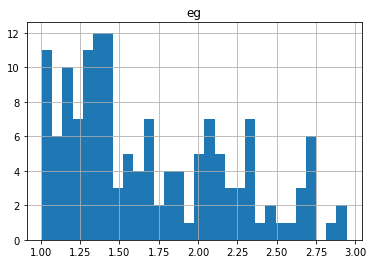

In [175]:
data.hist(bins=30)
plt.show()

In [204]:
dataset1 = data

Get Book Value 

In [241]:
def get_bookvalue_growth(df):
    
    '''Returns earnings growth for all companies earning money'''
    
    # get the last three years of data [final]
    dff = df[df['year'].between(df.year.max()-2,df.year.max(), inclusive=True)]
    # get the first three years of data [initial]
    dfi = df[df['year'].between(df.year.min(),df.year.min()+2, inclusive=True)]
    
    mean_bookvalue_final = dff.BookValuePerShare.mean()
    mean_bookvalue_initi = dfi.BookValuePerShare.mean()
    
    bookval_growth =(mean_bookvalue_final - mean_bookvalue_initi)/mean_bookvalue_initi
    
    if mean_bookvalue_final<0 or mean_bookvalue_initi<0:
        return None
    
    return bookval_growth

In [245]:
data = []
s  = stocks(xetra)
for _ in range(0,len(xetra)):
    df = get_fundamentals(fundamentals, s.isin)
    bg = get_bookvalue_growth(df)
    if not pd.isnull(bg) and bg<np.inf and bg>-np.inf:
        data.append([s.name,s.isin,bg])
    s.switch_next()
data = pd.DataFrame(data,columns=['name','isin','bg'])

In [247]:
dataset2 = data

In [190]:
data.describe()

,bg
count,1307.000000
mean,0.933369
std,2.161165
min,-1.000000
25%,0.096022
50%,0.592141
75%,1.175456
max,36.686567


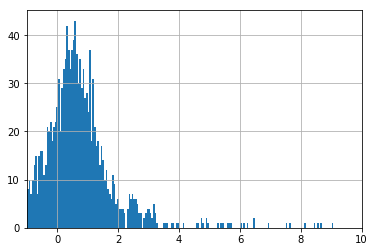

In [199]:
data.bg.hist(bins=700)
plt.xlim(-1,10)
plt.show()

## Get return on equity

In [77]:
data = pd.Series()
for _isin in fundamentals.ISIN.unique():
    df = get_fundamentals(fundamentals, _isin)
    data = data.append(df['ReturnonEquity'],ignore_index=True)
data=data[(data>-100) & (data<100)]

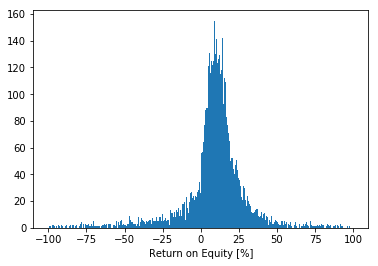

In [80]:
plt.hist(data,bins=1000)
plt.xlabel('Return on Equity [%]')
plt.show()

In [81]:
data.describe()

count    16375.000000
mean         8.899710
std         21.079034
min        -99.820000
25%          3.690000
50%         10.180000
75%         17.540000
max         99.730000
dtype: float64

Algo strategy: select stocks which have a return on equity above x percent of all others. 

Backtesting: make sure to use only data which is known at the year of buying

## Check keyratios

In [9]:
s.keyratios

## Get quotes from database

In [6]:
s = stocks(xetra)
s.switch_isin('DE0005790430')

In [7]:
cnq        = sqlite3.connect('database/stocks_quotes.db')
quote      = pd.read_sql("SELECT * FROM `quotes` WHERE `isin` LIKE '%{0}%';".format(s.isin), cnq)

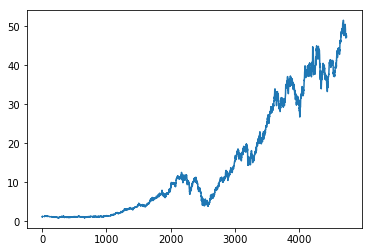

In [8]:
plt.plot(quote.close)
plt.show()

In [19]:
s.isin, s.name

('DE0005790430', 'FUCHS PETROL.SE VZO O.N.')

In [14]:
test = quote.date[0]
test

'1999-03-16 00:00:00'

In [19]:
dt.datetime.strptime??

In [36]:
def convert_dt(string):
    return dt.datetime.strptime(string,'%Y-%m-%d %H:%M:%S')

In [41]:
quote['date'] = quote['date'].apply(convert_dt)

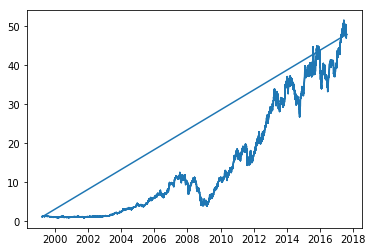

In [43]:
plt.plot(quote.date,quote.close)
plt.show()

In [44]:
quote.date.unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

# Toms' algo to load dividend history

In [ ]:

class HistoryDownloader(object):
    u"""Downloads history from http://financials.morningstar.com/
    """

    def __init__(self, table_prefix = u'morningstar_'):
        u"""Constructs the HistoryDownloader instance.
        :param table_prefix: Prefix of the MySQL tables.
        """
        self._table_prefix = table_prefix
    
    def download(self, ticker, start, stop, conn = None):
        u"""Downloads and returns a dictionary containing pandas.DataFrames
        representing the history (i.e. dividend history, OHLC Volume Ticker,
        fairvalue ???) for the given Morningstar ticker. If the MySQL connection
        is specified then the downloaded financials are uploaded to the MySQL
        database.
        :param ticker: Morningstar ticker.
        :param start: starting date for history 
        :param stop : end date for history
        :param conn: MySQL connection.
        :return Dictionary containing pandas.DataFrames representing the
        financials for the given Morningstar ticker.
        """
        result = {}

        ##########################
        # Error Handling
        ##########################

        # Empty String
        if len(ticker) == 0:
            raise ValueError("You did not enter a ticker symbol.  Please"
                             " try again.")
        
        frame = self._download(ticker, start, stop)
        result['dividend_table'] = frame[0]
        result['history_table'] = frame[1]
        result['fairvalue_table'] = frame[2]
#         for report_type, table_name in [
#                 (u'DividendData', u'dividend_history'),
#                 (u'bs', u'balance_sheet'),
#                 (u'cf', u'cash_flow')]:
#             frame = self._download(ticker, start, stop)
#             result[table_name] = frame
#             if conn:
#                 self._upload_frame(
#                     frame, ticker, self._table_prefix + table_name, conn)
#         if conn:
#             self._upload_unit(ticker, self._table_prefix + u'unit', conn)
#         result[u'period_range'] = self._period_range
#         result[u'fiscal_year_end'] = self._fiscal_year_end
#         result[u'currency'] = self._currency
        return result
    
    def _parse_morningstar_hist_dict_to_dfs(self,jsondata):
        """ 
        Parses the downloaded data into 3 dataframes : dividend historical data, 
historical data and fair value data
        """
        df_dividend = pd.DataFrame(jsondata['DividendData'])
        df_dividend.Desc= [float(y[0]) if len(y)>0 else np.NaN for y in 
[re.findall("\d+\.\d+",x) for x in df_dividend.Desc.values]]
        list_dt = [serial_date_to_string(t) for t in 
jsondata['PriceDataList'][0]['DateIndexs']]
        list_volume = [int(round(j*1e6)) for j in 
jsondata['VolumeList']['Datapoints']]
        list_columns = ["Open","High","Low","Close"]
        list_symbol = [jsondata['PriceDataList'][0]['Symbol']] * len(list_volume)
        df_hist = 
pd.DataFrame(jsondata['PriceDataList'][0]['Datapoints'],columns=list_columns)
        df_hist['Date'] = list_dt
        df_hist['Volume'] = list_volume
        df_hist['Symbol'] = list_symbol
        df_fairvalue = pd.DataFrame(jsondata['FairValueList'])
    #     df_min = pd.DataFrame(JSONDATA['Min'])
    #     df_max = pd.DataFrame(JSONDATA['Max'])
    #     df_pricetype = pd.DataFrame(JSONDATA['PriceType'])
        return df_dividend, df_hist, df_fairvalue
    
    def _download(self, ticker, start, stop):
        u"""Downloads and returns a pandas.DataFrame corresponding to the
        given Morningstar ticker and the given type of the report.
        :param ticker: Morningstar ticker.
        :param report_type: Type of the report ('is', 'bs', 'cf').
        :return  pandas.DataFrame corresponding to the given Morningstar ticker
        and the given type of the report.
        """
        url = (r'http://globalquote.morningstar.com/globalcomponent/' +
               r'RealtimeHistoricalStockData.ashx?ticker=' + ticker +
               r'&showVol=true&dtype=his&f=d&curry=EUR&range=' + start + '|' + 
stop +
               r'&isD=true&isS=true&hasF=true&ProdCode=DIRECT')
        with urllib.request.urlopen(url) as response:
            json_text = response.read().decode(u'utf-8')
            # print(json_text)
            ##############################
            # Error Handling
            ##############################

            # Wrong ticker
            if len(json_text)==0:
                raise ValueError("MorningStar cannot find the ticker symbol "
                                 "you entered or it is INVALID. Please try "
                                 "again.")

            json_data = json.loads(json_text.replace('<br>','')) 
#s.replace('\r\n', '')
            #print(json_data)
        return self._parse_morningstar_hist_dict_to_dfs(json_data)

In [ ]:
url = (r'http://globalquote.morningstar.com/globalcomponent/' +
               r'RealtimeHistoricalStockData.ashx?ticker=' + ticker +
               r'&showVol=true&dtype=his&f=d&curry=EUR&range=' + start + '|' + 
stop +
               r'&isD=true&isS=true&hasF=true&ProdCode=DIRECT')

In [ ]:
'http://globalquote.morningstar.com/globalcomponent/RealtimeHistoricalStockData.ashx?ticker=F&showVol=true&dtype=his&f=d&curry=USD&range=1900-1-1|2014-10-10&isD=true&isS=true&hasF=true&ProdCode=DIRECT '